# Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from typing import Any, List, Dict, Tuple
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
from tqdm import tqdm

C:\Users\vgtra\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Functions and classes

In [2]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

In [3]:
class LazyClassifierFCA:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train
        
        
    def is_positive_classifier(self, intersection, strict, threshold, weight_type, n_classifier_threshold):
        # Find samples in X_train_positive that contain the intersection
        num_positive = ((self.X_train_positive | ~intersection) == True).all(axis=1).sum()
        num_negative = ((self.X_train_negative | ~intersection) == True).all(axis=1).sum()
#         print('Вид из positive:', num_positive, num_negative)
        
        if strict:
            bool_return = num_negative == 0 and num_positive > n_classifier_threshold
            return bool_return, 1
        else:
            proportion = float(num_positive)/(num_negative + num_positive)
            bool_return = num_positive > n_classifier_threshold and proportion >= threshold
            
            if weight_type == 'classic':
                return bool_return, 1
            
            elif weight_type == 'proportion':
                return bool_return, proportion
            
            elif weight_type == 'num_classifiers':
                return bool_return, num_positive

    def is_negative_classifier(self, intersection, strict, threshold, weight_type, n_classifier_threshold):
        num_positive = ((self.X_train_positive | ~intersection) == True).all(axis=1).sum()
        num_negative = ((self.X_train_negative | ~intersection) == True).all(axis=1).sum()
        
        if strict:
            bool_return = num_positive == 0 and num_negative > n_classifier_threshold
            return bool_return, 1
        else:
            proportion = float(num_negative)/(num_positive + num_negative)
            bool_return = num_negative > n_classifier_threshold and proportion >= threshold
            
            if weight_type == 'classic':
                return bool_return, 1
            
            if weight_type == 'proportion':
                return bool_return, proportion
            
            if weight_type == 'num_classifiers':
                return bool_return, num_negative
        
    def classify_sample(
        self, 
        sample: pd.Series, 
        strict, 
        threshold, 
        weight_type, 
        n_classifier_threshold, 
        verbose=0,
        return_classifiers=False
    ) -> Any:
        
        self.X_train_positive = self.X_train[y_train == 1]
        self.X_train_negative = self.X_train[y_train == 0]
        
        positive_classifiers = 0
        negative_classifiers = 0
        
        # Check for positive classifiers by intersecting sample with each positive object
        for _, pos_sample in self.X_train_positive.iterrows():
            intersection = sample & pos_sample
            positive_classifier = self.is_positive_classifier(intersection, strict, threshold, weight_type, n_classifier_threshold)
            
            if positive_classifier[0]:
                positive_classifiers += positive_classifier[1]

        # Check for negative classifiers by intersecting sample with each negative object
        for _, neg_sample in self.X_train_negative.iterrows():
            intersection = sample & neg_sample
            negative_classifier = self.is_negative_classifier(intersection, strict, threshold, weight_type, n_classifier_threshold)
            
            if negative_classifier[0]:
                negative_classifiers += negative_classifier[1]
                
        if verbose == 1:
            print(f'Neg={negative_classifiers}, Pos={positive_classifiers}')
        if return_classifiers == True:
            if positive_classifiers > negative_classifiers:
                return 1, positive_classifiers, negative_classifiers  # Predict positive

            elif negative_classifiers > positive_classifiers:
                return 0, positive_classifiers, negative_classifiers  # Predict negative

            elif negative_classifiers == positive_classifiers:
                return 1, positive_classifiers, negative_classifiers  # or 0, depending on the choice
            else:
                return 1, positive_classifiers, negative_classifiers  # or 0, depending on the choice
        else:
            if positive_classifiers > negative_classifiers:
                return 1  # Predict positive

            elif negative_classifiers > positive_classifiers:
                return 0  # Predict negative

            elif negative_classifiers == positive_classifiers:
                return 1  # or 0, depending on the choice
            else:
                return 1  # or 0, depending on the choice


    def predict(
        self, X_test: pd.DataFrame, strict=True, 
        threshold=0.9, n_classifier_threshold=1,
        weight_type='classic', 
        verbose=0
    ) -> List[Any]:
        
        predictions = []
        
        # Iterate through each sample in X_test
        for _, sample in tqdm(X_test.iterrows(), disable=bool(verbose)):
            
            prediction = self.classify_sample(
                sample, strict, threshold, 
                weight_type, n_classifier_threshold, verbose
            )
            predictions.append(prediction)
        
        
        return predictions

In [4]:
class OrdinalScaler():
    '''
        Scales numerical data using ordinal scale. 
        Uses tresholds defined by user, if none provided uses 25%, 50% and 75% as tresholds
    '''
    
    def __init__(self, column, inter_ordinal=False):
        self.column = column
        self.inter_ordinal = inter_ordinal
        
    def fit(self, data, list_of_tresholds=[]):
        if len(list_of_tresholds) == 0:
            self.tresholds = data[self.column].agg([percentile(0.25), percentile(0.5), percentile(0.75)]).values
        else:
            self.tresholds = np.array(list_of_tresholds)
        
    
    def scale(self, data):
        '''
            Builing an ordinal scale of a given colum of a dataframe, 
            using list_of_tresholds checking every treshold using non strict comparison >=
        '''
        length_h = len(data.index)
        length_w = len(self.tresholds) if self.inter_ordinal == False else len(self.tresholds)*2

        arr = np.zeros((length_h, length_w))

        for i, value in enumerate(data[self.column]):
            if self.inter_ordinal == True:
                arr[i, :] = np.concatenate([self.tresholds >= value, self.tresholds <= value])
            else:
                arr[i, :] = self.tresholds >= value
            
        if self.inter_ordinal == True:
            less = [f'{self.column}<={treshold}' for treshold in self.tresholds]
            more = [f'{self.column}=>{treshold}' for treshold in self.tresholds]
            columns_names = less + more
        else:
            columns_names = [f'{self.column}<={treshold}' for treshold in self.tresholds]

        ordinal_df = pd.DataFrame(arr.astype(dtype=bool), columns=columns_names, index=data.index)

        return ordinal_df
    
    def get_tresholds(self):
        return self.tresholds

In [5]:
# df['Pregnancies']

In [6]:
def EDA_plot(col):

    nrows, ncols = 2, 1 

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12*ncols, 4*nrows))
    
    sns.kdeplot(df, x=col, fill=True, hue='Outcome',
                linewidth=2, palette='rocket', alpha=0.6, 
                ax=ax[0])
    ax[0].set_xlabel(xlabel=col, fontsize=12, weight='bold')
    ax[0].set_ylabel(ylabel='Density', fontsize=12, weight='bold')
    
    ax[0].set_xlim(df[col].min(), df[col].max())
    
    
    sns.kdeplot(df, x=col, fill=True, linewidth=1, multiple='fill',
                color='#5c1031', alpha=0.6, edgecolor='k', hue='Outcome',
                ax=ax[1])
    ax[1].set_xlabel(xlabel=col, fontsize=12, weight='bold')
    ax[1].set_ylabel(ylabel='Density', fontsize=12, weight='bold')
    ax[1].set_xlim(df[col].min(), df[col].max())
    
    return ax

# Data import

In [7]:
# https://www.kaggle.com/datasets/nanditapore/healthcare-diabetes
    
import opendatasets as od 

dataset_name = 'cancer-prediction-dataset'

od.download("https://www.kaggle.com/datasets/nanditapore/healthcare-diabetes") 

path = 'healthcare-diabetes/Healthcare-Diabetes.csv'
df = pd.read_csv(path)

# Since LazyFCA is relativly slow algorithm I've truncated dataset to a 1000 instances
# I've also decided to balance classes to make it easier to understand the results
df_0 = df[df['Outcome'] == 0].sample(n=500, ignore_index=True, random_state=1).drop(['Id'], axis=1)
df_1 = df[df['Outcome'] == 1].sample(n=500, ignore_index=True, random_state=1).drop(['Id'], axis=1)

df = pd.concat([df_0, df_1], ignore_index=True)

df.head()

Skipping, found downloaded files in ".\healthcare-diabetes" (use force=True to force download)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,129,80,0,0,31.2,0.703,29,0
1,6,123,72,45,230,33.6,0.733,34,0
2,2,139,75,0,0,25.6,0.167,29,0
3,3,81,86,16,66,27.5,0.306,22,0
4,7,94,64,25,79,33.3,0.738,41,0


In [8]:
df.shape

(1000, 9)

# EDA

In [9]:
df.describe(include='all')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,3.979000,125.057000,69.580000,21.380000,83.192000,32.758800,0.482721,34.237000,0.50000
std,3.381419,31.701873,19.636527,16.371977,117.258999,8.067296,0.327998,11.729724,0.50025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085000,21.000000,0.00000
25%,1.000000,102.000000,64.000000,0.000000,0.000000,27.900000,0.249000,25.000000,0.00000
50%,3.000000,122.000000,72.000000,24.000000,36.000000,32.800000,0.375500,30.000000,0.50000
75%,6.000000,146.000000,80.000000,35.000000,132.000000,37.400000,0.640000,42.000000,1.00000
max,17.000000,199.000000,122.000000,99.000000,600.000000,67.100000,2.420000,81.000000,1.00000


### Target distribution

Distribution is skewed towards class 0. To asses the quality of the model correctly we need to use metrics that work with unbalanced classes

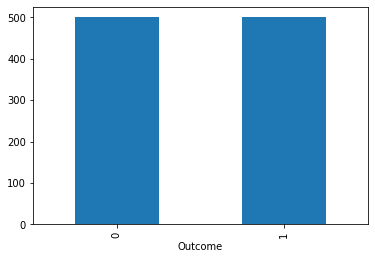

In [10]:
_ = df['Outcome'].value_counts().plot.bar()

### Attributes corelation with target

Glucose and Insulin are corellated (0.323445) since glucose is heavily corellated with target it is sensable to remove Insulin from the dataset if the model will be overfitting. Also Skin thickness and insulin are corelated (0.445345), so it is yet another indicator that insulin might affect the predictions badly, however if we were making conclusions based on the general knowlege of diabities this assumption would be counterintuitive since insulin is one of the most important chemical in the diabities, so further research is needed

In [11]:
corr = df.select_dtypes('number').corr()

corr['Outcome'].sort_values()

BloodPressure               0.100170
SkinThickness               0.102543
DiabetesPedigreeFunction    0.173743
Insulin                     0.198566
Age                         0.236867
Pregnancies                 0.249428
BMI                         0.300524
Glucose                     0.486871
Outcome                     1.000000
Name: Outcome, dtype: float64

<Axes: >

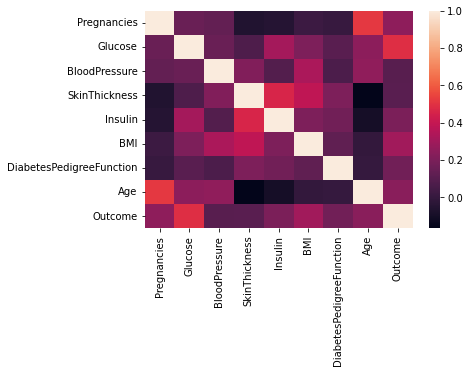

In [12]:
import seaborn as sns
%matplotlib inline

sns.heatmap(corr)

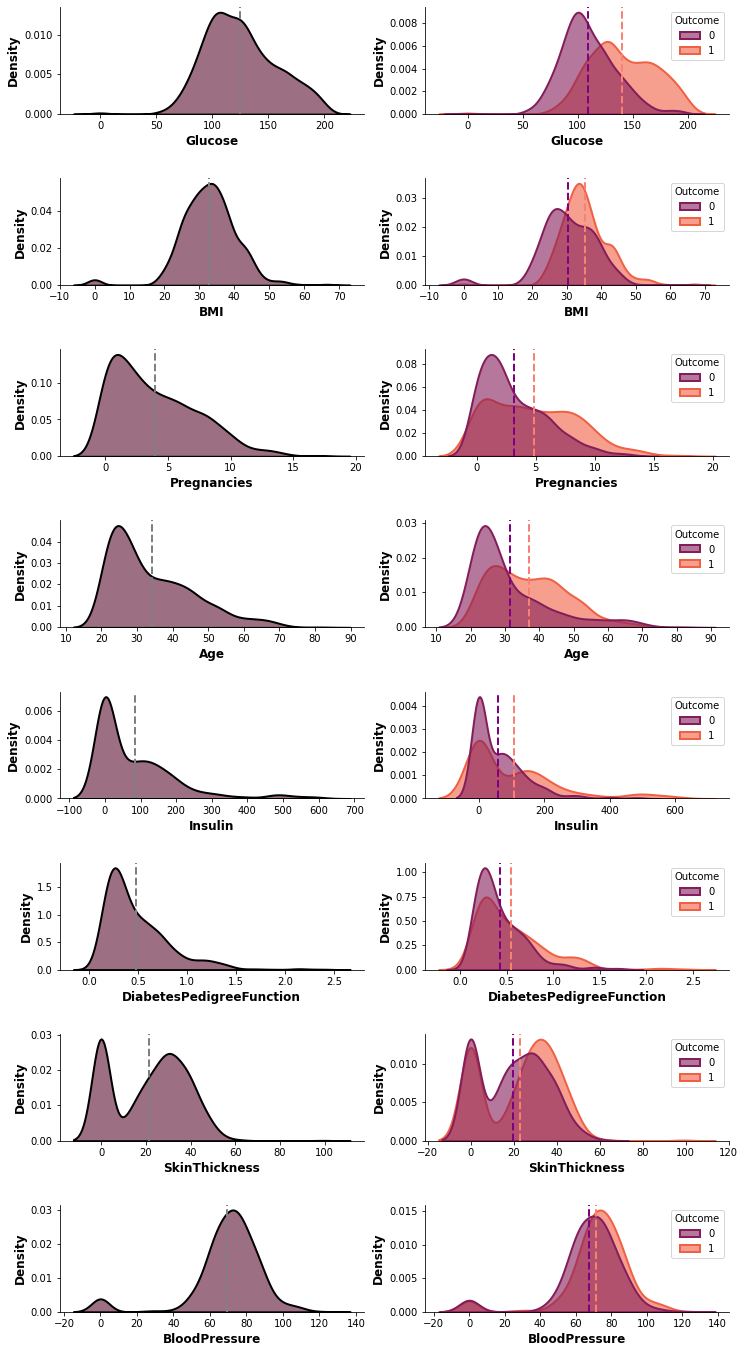

In [13]:
plotIndex = 1

columns = corr['Outcome'].sort_values(ascending = False)[1:].index

nrows, ncols = len(columns), 2 

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(6*ncols, 3*nrows))

for i, col in enumerate(columns):
# for col in ['Insulin']:
    
    sns.kdeplot(df, x=col, fill=True, linewidth=2, 
                color='#5c1031', alpha=0.6, edgecolor='k',
                ax=ax[i][0])
    
    ax[i][0].axvline(df[col].mean(), color='grey', linestyle='--', linewidth=2)
    
    ax[i][0].set_xlabel(xlabel=col, fontsize=12, weight='bold')
    ax[i][0].set_ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    sns.kdeplot(df, x=col, fill=True, hue='Outcome', 
                linewidth=2, palette='rocket', alpha=0.6, 
                ax=ax[i][1])
    
    
    ax[i][1].axvline(df[df['Outcome'] == 0][col].mean(), color='purple', linestyle='--', linewidth=2)
    ax[i][1].axvline(df[df['Outcome'] == 1][col].mean(), color='salmon', linestyle='--', linewidth=2)
    
    ax[i][1].set_xlabel(xlabel=col, fontsize=12, weight='bold')
    ax[i][1].set_ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    
plt.subplots_adjust(hspace=0.6)    
plt.show()

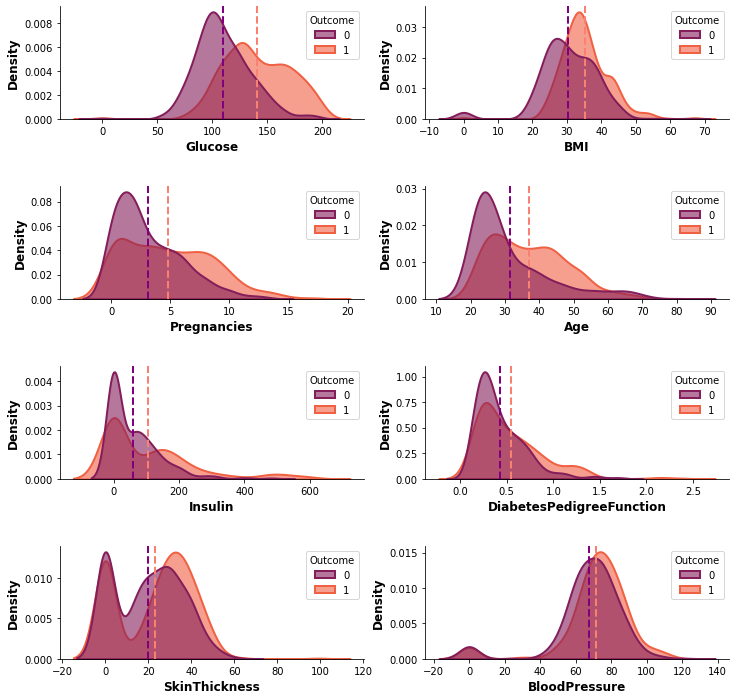

In [14]:
plotIndex = 1

columns = corr['Outcome'].sort_values(ascending = False)[1:].index

nrows, ncols = len(columns)//2, 2 

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(6*ncols, 3*nrows))

for i, col in enumerate(columns):
# for col in ['Insulin']:
    
#     sns.kdeplot(df, x=col, fill=True, linewidth=2, 
#                 color='#5c1031', alpha=0.6, edgecolor='k',
#                 ax=ax[i][0])
    
#     ax[i][0].axvline(df[col].mean(), color='grey', linestyle='--', linewidth=2)
    
#     ax[i][0].set_xlabel(xlabel=col, fontsize=12, weight='bold')
#     ax[i][0].set_ylabel(ylabel='Density', fontsize=12, weight='bold')
#     sns.despine()

    

    sns.kdeplot(df, x=col, fill=True, hue='Outcome', 
                linewidth=2, palette='rocket', alpha=0.6, 
                ax=ax[i//2][i%2])
    
    
    ax[i//2][i%2].axvline(df[df['Outcome'] == 0][col].mean(), color='purple', linestyle='--', linewidth=2)
    ax[i//2][i%2].axvline(df[df['Outcome'] == 1][col].mean(), color='salmon', linestyle='--', linewidth=2)
    
    ax[i//2][i%2].set_xlabel(xlabel=col, fontsize=12, weight='bold')
    ax[i//2][i%2].set_ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    
plt.subplots_adjust(hspace=0.6)    
plt.show()

### Glucose

Good tresholds for Glucose can be seen below. For analysis of better tresholds I ploted mean outcome of a current value as well as number of samples of current value. By visual analysis I've chosen [75, 118, 153]

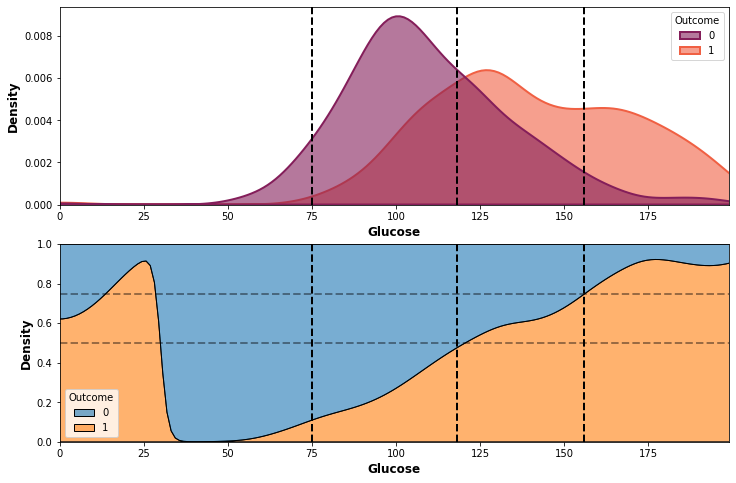

In [15]:
custom_tresholds = {}
custom_tresholds['Glucose'] = [75, 118, 156]

ax = EDA_plot('Glucose')

for value in custom_tresholds['Glucose']:
    ax[0].axvline(value, color='k', linestyle='--', linewidth=2)
    ax[1].axvline(value, color='k', linestyle='--', linewidth=2)

    
ax[1].axhline(0.5, color='k', linestyle='--', linewidth=2, alpha=0.4)
ax[1].axhline(0.75, color='k', linestyle='--', linewidth=2, alpha=0.4)
       
plt.show()

### BMI

good tresholds are 24 and 40, since for values <= 24 there are small chance of diabetes, for values between 24 and 40 - medium chance, for values higher than 40 - high chance of diabeties 

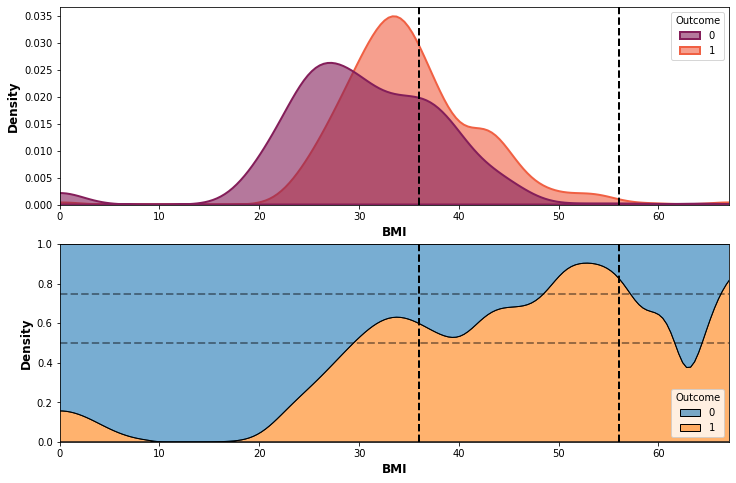

In [16]:
custom_tresholds['BMI'] = [24, 40, 70]

ax = EDA_plot('BMI')

custom_tresholds['BMI'] = [36, 56]

for value in custom_tresholds['BMI']:
    ax[0].axvline(value, color='k', linestyle='--', linewidth=2)
    ax[1].axvline(value, color='k', linestyle='--', linewidth=2)

    
ax[1].axhline(0.5, color='k', linestyle='--', linewidth=2, alpha=0.4)
ax[1].axhline(0.75, color='k', linestyle='--', linewidth=2, alpha=0.4)
       
plt.show()

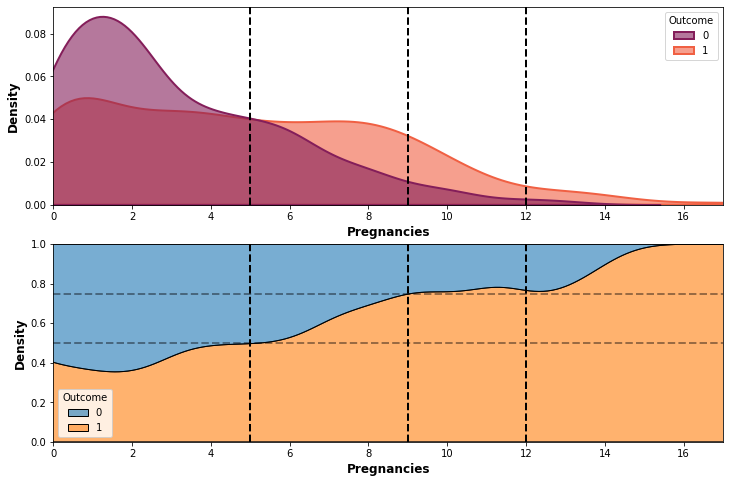

In [17]:
ax = EDA_plot('Pregnancies')

custom_tresholds['Pregnancies'] = [5, 9, 12]

for value in custom_tresholds['Pregnancies']:
    ax[0].axvline(value, color='k', linestyle='--', linewidth=2)
    ax[1].axvline(value, color='k', linestyle='--', linewidth=2)

    
ax[1].axhline(0.5, color='k', linestyle='--', linewidth=2, alpha=0.4)
ax[1].axhline(0.75, color='k', linestyle='--', linewidth=2, alpha=0.4)
       
plt.show()

### Age

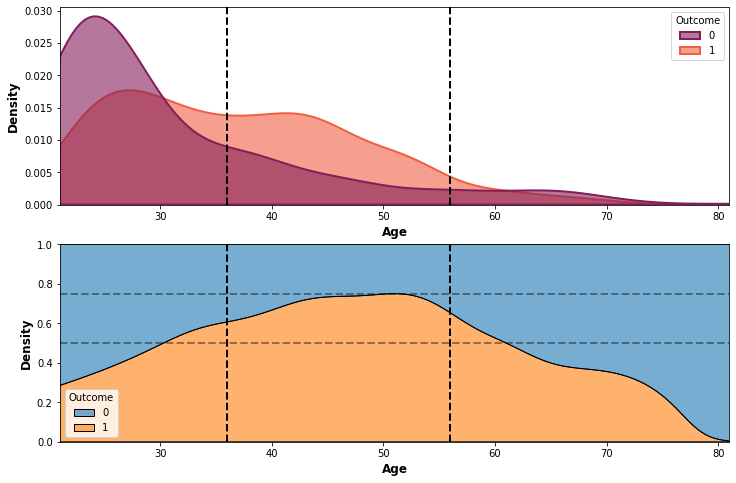

In [18]:
ax = EDA_plot('Age')

custom_tresholds['Age'] = [36, 56]

for value in custom_tresholds['Age']:
    ax[0].axvline(value, color='k', linestyle='--', linewidth=2)
    ax[1].axvline(value, color='k', linestyle='--', linewidth=2)

    
ax[1].axhline(0.5, color='k', linestyle='--', linewidth=2, alpha=0.4)
ax[1].axhline(0.75, color='k', linestyle='--', linewidth=2, alpha=0.4)
       
plt.show()

## Insulin

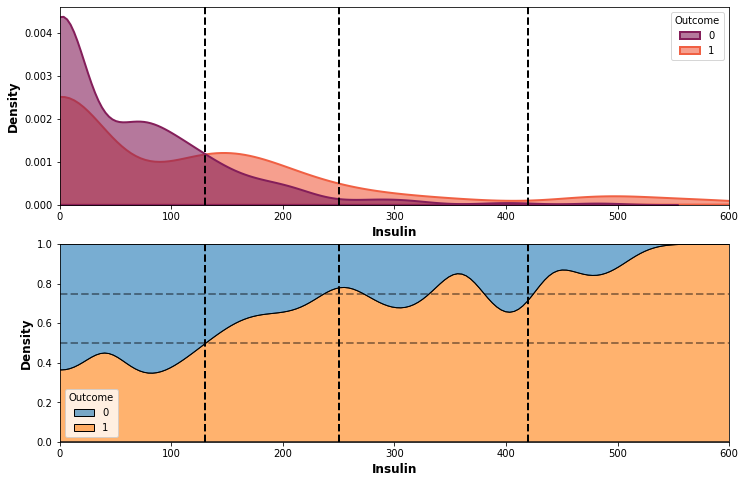

In [19]:
ax = EDA_plot('Insulin')

custom_tresholds['Insulin'] = [130, 250, 420]
for value in custom_tresholds['Insulin']:
    ax[0].axvline(value, color='k', linestyle='--', linewidth=2)
    ax[1].axvline(value, color='k', linestyle='--', linewidth=2)

    
ax[1].axhline(0.5, color='k', linestyle='--', linewidth=2, alpha=0.4)
ax[1].axhline(0.75, color='k', linestyle='--', linewidth=2, alpha=0.4)
       
plt.show()

## DiabetesPedigreeFunction

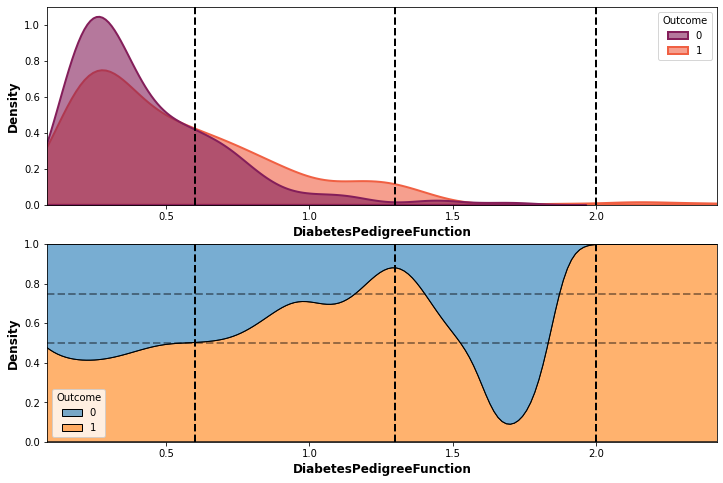

In [20]:
ax = EDA_plot('DiabetesPedigreeFunction')

custom_tresholds['DiabetesPedigreeFunction'] = [0.6, 1.3, 2]
for value in custom_tresholds['DiabetesPedigreeFunction']:
    ax[0].axvline(value, color='k', linestyle='--', linewidth=2)
    ax[1].axvline(value, color='k', linestyle='--', linewidth=2)

    
ax[1].axhline(0.5, color='k', linestyle='--', linewidth=2, alpha=0.4)
ax[1].axhline(0.75, color='k', linestyle='--', linewidth=2, alpha=0.4)
       
plt.show()

For the remaining attributes lets for now use 25%, 50%, 75% percentile since they are less important

# Preprocessing

I've removed skinthickness and blood pressure since they are weakly correlated with target and LazyFca algorthm will take longer time to classify objects

In [21]:
from sklearn.model_selection import train_test_split


def data_prep(df, scaling=True, small=True, interordinal=False, allow_custom_thresholds=True, custom_thresholds=dict()):
    if small == True:
        useful_columns = ['Pregnancies', 'Age', 'BMI', 'Glucose', 'Outcome']
    else:
        useful_columns = [
            'DiabetesPedigreeFunction', 'Insulin', 'Pregnancies', 
            'Age', 'BMI', 'Glucose', 'Outcome'
        ]
        
    
    df_useful = df[useful_columns]
        


    X_train, X_test, y_train, y_test = train_test_split(
            df_useful.drop(["Outcome"], axis=1), # X
            df_useful["Outcome"], # y
            test_size=0.2, # доля от всех записей
            random_state=777, # зерно
            stratify=df_useful["Outcome"]
    )

    X_test = X_test[:100]
    y_test = y_test[:100]
    
    if scaling == False:
        return X_train, X_test, y_train, y_test
        
    X_train_scaled = pd.DataFrame(index = X_train.index)
    X_test_scaled = pd.DataFrame(index = X_test.index)

    scaler_dict = {}

    for column in X_train:
        scaler_dict[column] = OrdinalScaler(column, interordinal)
        if column in custom_thresholds.keys() and allow_custom_thresholds==True:
            scaler_dict[column].fit(X_train, custom_thresholds[column])
        else:
            scaler_dict[column].fit(X_train, [])
        scaled_data = scaler_dict[column].scale(X_train)
        scaled_data_test = scaler_dict[column].scale(X_test)
        X_train_scaled = pd.concat([X_train_scaled, scaled_data], axis=1)
        X_test_scaled = pd.concat([X_test_scaled, scaled_data_test], axis=1)


    return X_train_scaled, X_test_scaled, y_train, y_test
    

In [22]:
X_train_scaled, X_test_scaled, y_train, y_test = data_prep(df, small=False, interordinal=True, allow_custom_thresholds=False)

In [23]:
X_train_scaled.head()

,DiabetesPedigreeFunction<=0.24675,DiabetesPedigreeFunction<=0.371,DiabetesPedigreeFunction<=0.62625,DiabetesPedigreeFunction=>0.24675,DiabetesPedigreeFunction=>0.371,DiabetesPedigreeFunction=>0.62625,Insulin<=0.0,Insulin<=36.0,Insulin<=135.0,Insulin=>0.0,Insulin=>36.0,Insulin=>135.0,Pregnancies<=1.0,Pregnancies<=3.0,Pregnancies<=6.0,Pregnancies=>1.0,Pregnancies=>3.0,Pregnancies=>6.0,Age<=25.0,Age<=30.0,Age<=41.0,Age=>25.0,Age=>30.0,Age=>41.0,BMI<=27.8,BMI<=32.8,BMI<=37.4,BMI=>27.8,BMI=>32.8,BMI=>37.4,Glucose<=102.0,Glucose<=123.0,Glucose<=147.0,Glucose=>102.0,Glucose=>123.0,Glucose=>147.0
25,False,True,True,True,False,False,False,False,True,True,True,False,False,False,True,True,True,False,False,True,True,True,False,False,True,True,True,True,False,False,True,True,True,False,False,False
395,False,True,True,True,False,False,False,False,True,True,True,False,True,True,True,True,False,False,True,True,True,False,False,False,False,False,True,True,True,False,True,True,True,False,False,False
696,False,True,True,True,False,False,True,True,True,True,False,False,False,False,False,True,True,True,False,False,False,True,True,True,False,True,True,True,False,False,False,True,True,True,False,False
287,False,False,True,True,True,False,False,False,False,True,True,True,True,True,True,True,False,False,True,True,True,False,False,False,False,False,False,True,True,True,False,False,True,True,True,False
474,True,True,True,False,False,False,True,True,True,True,False,False,False,True,True,True,False,False,True,True,True,False,False,False,False,False,True,True,True,False,False,True,True,True,False,False


# Metric keeper

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def metric_keeper(name_of_model, y_test, y_pred, df=None):
    
    if df is None:
        df = pd.DataFrame(columns=[
            'accuracy', 'F1', 'TN', 'FP', 'FN', 'TP',
            'Specificity', 'Sensitivity_Recall', 'FPR', 'FDR', 'Precision'
        ])
    
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).reshape(-1,)

    Specificity = TN/(TN+FP)
    Sensitivity_Recall = TP/(FN+TP)

    accuracy = accuracy_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    # NPV = TP/(TP+FP)
    FPR = FP/(FP+TN)
    FDR = FP/(FP+TP)

    Precision = TP/(TP+FP)
    
    metric_arr = [accuracy, F1, TN, FP, FN, TP, Specificity, Sensitivity_Recall, FPR, FDR, Precision]
    df.loc[name_of_model] = metric_arr
    return df
    

# Training Lazy classificator

In [25]:
metric_df = pd.DataFrame(columns=[
            'accuracy', 'F1', 'TN', 'FP', 'FN', 'TP',
            'Specificity', 'Sensitivity_Recall', 'FPR', 'FDR', 'Precision'
        ])

In [26]:
X_train_scaled, X_test_scaled, y_train, y_test = data_prep(df, small=False, interordinal=True, allow_custom_thresholds=False)
X_train_scaled.shape

(800, 36)

In [28]:
for small in [True, False]:
    for interordinal in [True, False]:
        for custom_thresholds in [True, False]:
            for strict in [True, False]:
                X_train_scaled, X_test_scaled, y_train, y_test = data_prep(
                    df, 
                    small=small, 
                    interordinal=interordinal, 
                    allow_custom_thresholds=custom_thresholds,
                    custom_thresholds=custom_tresholds,
                )

                classifier = LazyClassifierFCA()
                classifier.fit(X_train_scaled, y_train)
                if strict == False:
                    for threshold in [0.8, 0.9]:
                        y_lazy_pred = classifier.predict(X_test_scaled, strict=strict, threshold=threshold)

                        name = 'LazyFCA {} {} {} {} {}.'.format(
                            'small' if small else 'big',
                            'inter' if interordinal else 'ord',
                            'cust' if custom_thresholds else 'base',
                            'soft',
                             threshold
                        )

                        metric_df2 = metric_keeper(name, y_test, y_lazy_pred, metric_df2)
                        print(name, metric_df2.tail(1).values[0])
                else:

                    y_lazy_pred = classifier.predict(X_test_scaled, strict=strict)

                    name = 'LazyFCA {} {} {} {}.'.format(
                        'small' if small else 'big',
                        'inter' if interordinal else 'ord',
                        'cust' if custom_thresholds else 'base',
                        'strict'
                    )

                    metric_df = metric_keeper(name, y_test, y_lazy_pred, metric_df)
                    print(name, metric_df2.tail(1).values[0])

In [ ]:
metric_df.sort_values('accuracy', ascending=False)

# Best Lazy

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = data_prep(
    df, 
    small=False, 
    interordinal=True, 
    allow_custom_thresholds=False
)

classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

# y_lazy_pred = classifier.predict(X_test_scaled, strict=True)

In [ ]:
X_test_scaled.values[0]

In [ ]:
preds = []
pos_arr = []
neg_arr = []
for i in tqdm(range(100)):
    pred, pos, neg = classifier.classify_sample(
            X_test_scaled.values[i], 
            strict=True, 
            threshold=1, 
            weight_type=None, 
            n_classifier_threshold=1, 
            verbose=0,
            return_classifiers=True
        )
    
    pos_arr.append(pos)
    neg_arr.append(neg)
    preds.append(pred)

In [ ]:
print(f'Average num of positive hyp = {np.mean(pos_arr)}, Average num of negative hyp = {np.mean(neg_arr)}')

# Training other models

In [29]:
%%time

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Function to measure split quality
    'splitter': ['best', 'random'],                # Strategy to choose the split at each node
    'max_depth': [None, 10, 20, 30, 40, 50],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20],           # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4, 10],             # Minimum number of samples to be at a leaf node
    'max_features': ['sqrt', 'log2', None]         # Number of features to consider for the best split
}

dtc = DecisionTreeClassifier(random_state=0)

clf = GridSearchCV(dtc, param_grid, scoring="f1_macro", verbose=1, cv=4)

clf.fit(X_train_scaled, y_train)

best_tree_model = clf.best_estimator_
best_tree_model.fit(X_train_scaled, y_train)

y_true, y_pred = y_test, best_tree_model.predict(X_test_scaled)

Fitting 4 folds for each of 1728 candidates, totalling 6912 fits
Wall time: 38.1 s


In [30]:
f1_score(y_test, y_pred)

0.74

In [31]:
metric_df = metric_keeper('small_DTC inter', y_test, y_pred, metric_df)
metric_df

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
small_DTC inter,0.74,0.74,37.0,15.0,11.0,37.0,0.711538,0.770833,0.288462,0.288462,0.711538


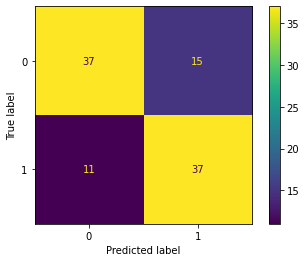

In [32]:
_ = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# KNN

In [33]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = data_prep(df, small=False, scaling=False)

# Define the k-NN classifier
knn = KNeighborsClassifier()

# Set up the parameter grid for GridSearch
param_grid = {
    'n_neighbors': np.arange(1, 31, 2),  # Odd numbers for better tie-breaking
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

# Evaluate the best model on the test set
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

metric_df = metric_keeper('big_Knn numeric', y_test, y_pred, metric_df)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'distance'}
Best Cross-Validation Score: 0.885


In [34]:
metric_df.tail()

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
small_DTC inter,0.74,0.74,37.0,15.0,11.0,37.0,0.711538,0.770833,0.288462,0.288462,0.711538
big_Knn numeric,0.88,0.88,44.0,8.0,4.0,44.0,0.846154,0.916667,0.153846,0.153846,0.846154


# Naive Bayes

In [35]:
from sklearn.naive_bayes import GaussianNB


X_train, X_test, y_train, y_test = data_prep(df, small=False, scaling=False)

# Initialize a Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Define a parameter grid
# Naive Bayes has fewer hyperparameters to tune. Here, we tune the var_smoothing parameter.
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

# Evaluate the best model on the test set
best_gnb = grid_search.best_estimator_
y_pred = best_gnb.predict(X_test)


metric_df = metric_keeper('big_Naive Bayes numeric', y_test, y_pred, metric_df)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Parameters: {'var_smoothing': 1e-07}
Best Cross-Validation Score: 0.7375


In [36]:
metric_df.tail()

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
small_DTC inter,0.74,0.740000,37.0,15.0,11.0,37.0,0.711538,0.770833,0.288462,0.288462,0.711538
big_Knn numeric,0.88,0.880000,44.0,8.0,4.0,44.0,0.846154,0.916667,0.153846,0.153846,0.846154
big_Naive Bayes numeric,0.81,0.781609,47.0,5.0,14.0,34.0,0.903846,0.708333,0.096154,0.128205,0.871795


# LogisticRegression

In [37]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = data_prep(df, small=False, scaling=False)

log_reg = LogisticRegression(max_iter=1000)

# Define the parameter grid
param_grid = {
    'penalty': ['l2', 'l1'],  # Regularization types
    'C': [0.01, 0.1, 1, 10, 100],                 # Inverse of regularization strength
    'solver': ['saga', 'liblinear'],     # Solvers
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

# Evaluate the best model on the test set
best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.74375


In [38]:
metric_df = metric_keeper('big_LogReg numeric', y_test, y_pred, metric_df)

In [39]:
metric_df.tail()

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
small_DTC inter,0.74,0.740000,37.0,15.0,11.0,37.0,0.711538,0.770833,0.288462,0.288462,0.711538
big_Knn numeric,0.88,0.880000,44.0,8.0,4.0,44.0,0.846154,0.916667,0.153846,0.153846,0.846154
big_Naive Bayes numeric,0.81,0.781609,47.0,5.0,14.0,34.0,0.903846,0.708333,0.096154,0.128205,0.871795
big_LogReg numeric,0.76,0.733333,43.0,9.0,15.0,33.0,0.826923,0.687500,0.173077,0.214286,0.785714


# RandomForestClassifier

In [40]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = data_prep(df, small=False, scaling=False)

# Initialize a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],              # Number of trees
    'max_depth': [None, 10, 20, 30],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be a leaf node
    'bootstrap': [True, False],                 # Whether to use bootstrap sampling
    'criterion': ['gini', 'entropy'],           # Criterion for split quality
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

metric_df = metric_keeper('big_RFC numeric', y_test, y_pred, metric_df)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.9075


In [41]:
metric_df.tail()

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
small_DTC inter,0.74,0.740000,37.0,15.0,11.0,37.0,0.711538,0.770833,0.288462,0.288462,0.711538
big_Knn numeric,0.88,0.880000,44.0,8.0,4.0,44.0,0.846154,0.916667,0.153846,0.153846,0.846154
big_Naive Bayes numeric,0.81,0.781609,47.0,5.0,14.0,34.0,0.903846,0.708333,0.096154,0.128205,0.871795
big_LogReg numeric,0.76,0.733333,43.0,9.0,15.0,33.0,0.826923,0.687500,0.173077,0.214286,0.785714
big_RFC numeric,0.90,0.897959,46.0,6.0,4.0,44.0,0.884615,0.916667,0.115385,0.120000,0.880000


## Searching for optimal tresholds using decision tree classifier and numerical attributes

Since finding a tresholds by hand is very challeging task I've decided to use tresholds that decision tree classifier (DCT) provides. It is counterintuitive to do so, since DTC can be described as stochastic version of FCA based classifiers, but I've decided to try anyway

Firstly we need to train DCT on the numerical data

In [42]:
%%time


X_train, X_test, y_train, y_test = data_prep(df, small=True, scaling=False)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Function to measure split quality
    'splitter': ['best', 'random'],                # Strategy to choose the split at each node
    'max_depth': [None, 10, 20, 30, 40, 50],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20],           # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4, 10],             # Minimum number of samples to be at a leaf node
    'max_features': ['sqrt', 'log2', None]         # Number of features to consider for the best split
}


dtc = DecisionTreeClassifier(random_state=0)

clf = GridSearchCV(dtc, param_grid, scoring="f1_macro", verbose=1, cv=4)

clf.fit(X_train, y_train)

best_tree_model = clf.best_estimator_
best_tree_model.fit(X_train, y_train)

y_true, y_pred = y_test, best_tree_model.predict(X_test)

Fitting 4 folds for each of 1728 candidates, totalling 6912 fits
Wall time: 37.4 s


In [43]:
metric_df = metric_keeper('small_DTC numerical', y_test, y_pred, metric_df)
metric_df

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
small_DTC inter,0.74,0.740000,37.0,15.0,11.0,37.0,0.711538,0.770833,0.288462,0.288462,0.711538
big_Knn numeric,0.88,0.880000,44.0,8.0,4.0,44.0,0.846154,0.916667,0.153846,0.153846,0.846154
big_Naive Bayes numeric,0.81,0.781609,47.0,5.0,14.0,34.0,0.903846,0.708333,0.096154,0.128205,0.871795
big_LogReg numeric,0.76,0.733333,43.0,9.0,15.0,33.0,0.826923,0.687500,0.173077,0.214286,0.785714
big_RFC numeric,0.90,0.897959,46.0,6.0,4.0,44.0,0.884615,0.916667,0.115385,0.120000,0.880000
small_DTC numerical,0.92,0.918367,47.0,5.0,3.0,45.0,0.903846,0.937500,0.096154,0.100000,0.900000


## Treshold extraction from tree

Then we need to extract all features from DCT. The DCT graph can be seen below 

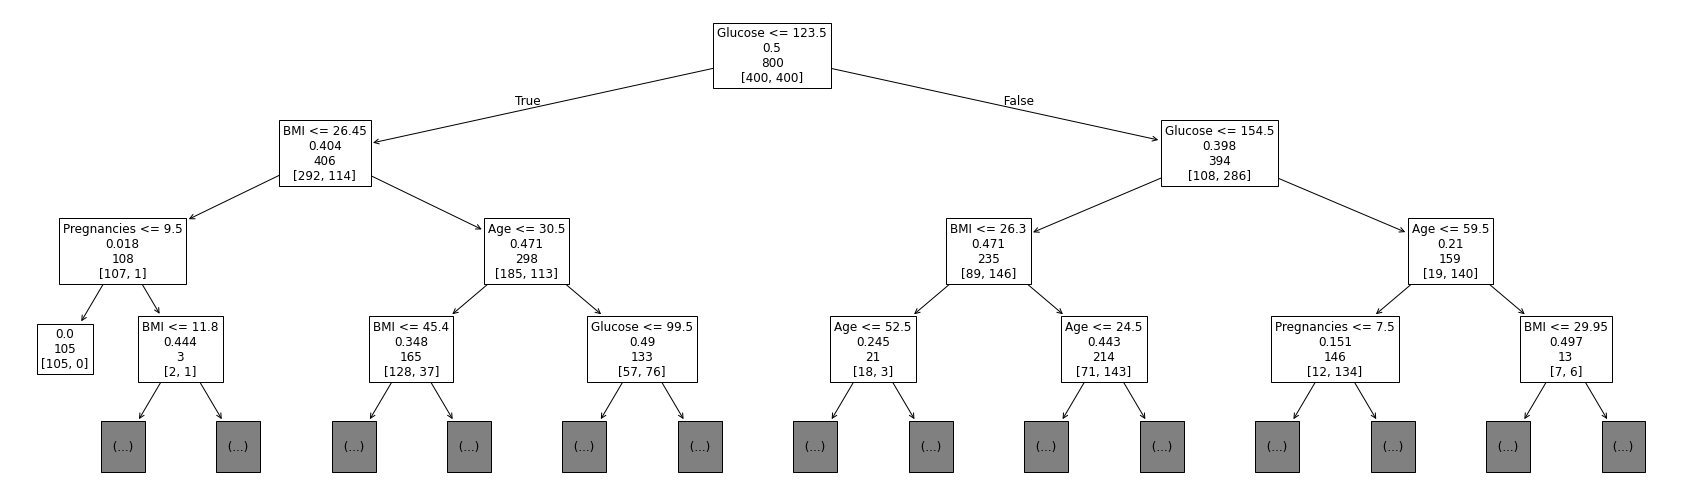

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


nrows, ncols = 1, 1

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(30, 9))

plot_tree(best_tree_model, ax=ax, feature_names=X_train.columns, max_depth=3, label='none', fontsize=12)
plt.show()

To extract needed fetures from DCT I used code from stackoverflow [[1]](https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree). I've changed it to my needs

In [46]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    '''
        returns repeating string containing in format:
        {depth};{name};{threshold};{impurity_metric};
    '''
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, depth):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            impurity = tree_.impurity[node]
            text ="{};{};{};".format(depth, name, threshold) 
            
            text_child1, impurity_child1 = recurse(tree_.children_left[node], depth + 1)
            text_child2, impurity_child2 = recurse(tree_.children_right[node], depth + 1)
            
            text+='{};'.format((impurity-min(impurity_child1, impurity_child2))/impurity)
            text+=text_child1
            text+=text_child2
            
            
            return text, impurity
        
        
        return '', tree_.impurity[node]
            
            
    text, _ = recurse(0, 1)
    return text

In [48]:
a = tree_to_code(best_tree_model, feature_names=X_train.columns)
a[:50]

'1;Glucose;123.5;0.20410214125589432;2;BMI;26.44999'

Parcing features into dicts:

In [49]:
def treshold_extraction(text):
    text_arr = text.split(';')[:-1]
    depth = text_arr[::4]
    columns = text_arr[1::4]
    values = text_arr[2::4]
    impurities = text_arr[3::4]
    
    print(len(text_arr), len(columns), len(values), len(impurities))
    
    treshold_dict = dict()
    
    for i, col in enumerate(columns):
        treshold_dict.setdefault(col, []).append((float(values[i]), float(impurities[i]), int(depth[i])))
        
    for i in treshold_dict:
        treshold_dict[i] = list(sorted(treshold_dict[i], key=lambda x: -x[-2]*1000+x[-1]))
    
    return treshold_dict

treshold_dict = treshold_extraction(a)
# treshold_dict['Age']

508 127 127 127


In [50]:
all_tresholds = {key: np.array(value)[:, 0] for key, value in treshold_dict.items()}
# all_tresholds['BMI']

## 3 random tresholds from the list

First simple idea of how the resulting data can be used: choose 3 random tresholds of every attribute. Pros: it is simople, cons: it probably won't show high effectivness  

In [51]:
np.random.seed(1)

In [ ]:
X_train_scaled = pd.DataFrame(index = X_train.index)
X_test_scaled = pd.DataFrame(index = X_test.index)

scaler_dict = {}

columns = ['Insulin', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age', 'BMI']

for column in X_train:
    scaler_dict[column] = OrdinalScaler(column, inter_ordinal=True)
    if column in all_tresholds.keys():
        scaler_dict[column].fit(X_train, np.random.choice(all_tresholds[column], size=3, replace=False))
    else:
        scaler_dict[column].fit(X_train, [])
    scaled_data = scaler_dict[column].scale(X_train)
    scaled_data_test = scaler_dict[column].scale(X_test)
    X_train_scaled = pd.concat([X_train_scaled, scaled_data], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, scaled_data_test], axis=1)
    
    
X_train_scaled.shape, X_test_scaled.shape

In [ ]:
classifier = LazyClassifierFCA()

classifier.fit(X_train_scaled, y_train)

In [ ]:
# y_lazy_pred = classifier.predict(X_test_scaled, strict=False)
y_lazy_pred = classifier.predict(X_test_scaled, strict=False, threshold=0.8)

In [ ]:
metric_df = metric_keeper('small_Lazy+DCT att. 3 random inter t=0.8', y_test, y_lazy_pred, metric_df)
metric_df

And it showed one of the worst results...

## 3 sparcly located tresholds

Second simple idea: sort tresholds from DCT and chose 3 that are the furthest from each other. If you look closely - many tresholds are located very tightly, the main idea - tresholds in small area don't boost metrics

In [ ]:
ordered_by_value = {key: sorted(value, key=lambda x:-x[0]) for key, value in treshold_dict.items()}
selected_tresholds = {key: sorted(value)[::len(value)//3] for key, value in all_tresholds.items()}
selected_tresholds

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = data_prep(
    df, 
    small=True, 
    interordinal=True, 
    allow_custom_thresholds=True,
    custom_thresholds=selected_tresholds)

X_train_scaled.shape

In [ ]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [ ]:
y_lazy_pred = classifier.predict(X_test_scaled, strict=False, threshold=0.8)

In [ ]:
metric_df = metric_keeper('small_Lazy+DCT att. 3 sparcly iter t=0.8', y_test, y_lazy_pred, metric_df)
metric_df

Better, but still worse than my tresholds

## 3 Most important tresholds

Third idea: DTCs use impurity metrics as measure of how good the division in the nodes are. I propose (and maybe I am terribly wrong in my assuption, I'm sorry) to use metric:

$metric = \frac{current\_impurity - min(left\_child\_impurity, right\_child\_impurity)}{current\_impurity}$

As a measure of importance of currecnt treshold. I will explain why I used this metric in my final presentation, if it will give some good results. By this measure we can sort tresholds and choose the most important

In [ ]:
ordered_by_impurity = {key: np.array(value)[-10:, 0] for key, value in treshold_dict.items()}
ordered_by_impurity

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = data_prep(
    df, 
    small=True, 
    interordinal=True, 
    allow_custom_thresholds=True,
    custom_thresholds=ordered_by_impurity)

X_train_scaled.shape

In [ ]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [ ]:
y_lazy_pred = classifier.predict(X_test_scaled, strict=False, threshold=0.9)

In [ ]:
metric_df = metric_keeper('small_Lazy+DCT att. 10 important inter t=0.9 new', y_test, y_lazy_pred, metric_df)
metric_df.tail()

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(y_test, y_lazy_pred)).plot()

Better! Even better than my tresholds, good sign

## 3 Ordered by depth

The final idea that I have - is to order tresholds by depth and choose the most shallow ones, since they probably have the most powerful divisions

In [ ]:
ordered_by_depth = {key: np.array(sorted(value, key=lambda x: -x[-1]))[-3:, 0] for key, value in treshold_dict.items()}
ordered_by_depth

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = data_prep(
    df, 
    small=True, 
    interordinal=True, 
    allow_custom_thresholds=True,
    custom_thresholds=ordered_by_depth)
    
X_train_scaled.shape

In [ ]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [ ]:
y_lazy_pred = classifier.predict(X_test_scaled, strict=False, threshold=0.8)

In [ ]:
metric_df = metric_keeper('small_Lazy+DCT att. 3 shallow inter t=0.8 new', y_test, y_lazy_pred, metric_df)
metric_df.tail()

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(y_test, y_lazy_pred)).plot()

Good result, I think this idea can be developed further

## 5 Ordered by depth

Just using more tresholds

In [ ]:
ordered_by_depth = {key: np.array(sorted(value, key=lambda x: -x[-1]))[-5:, 0] for key, value in treshold_dict.items()}
ordered_by_depth

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = data_prep(
    df, 
    small=True, 
    interordinal=True, 
    allow_custom_thresholds=True,
    custom_thresholds=ordered_by_depth)
    
X_train_scaled

In [ ]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [ ]:
y_lazy_pred = classifier.predict(X_test_scaled, strict=False, threshold=0.8)

In [ ]:
metric_df = metric_keeper('small_Lazy+DCT att. 5 shallow inter t=0.8 new', y_test, y_lazy_pred, metric_df)
metric_df.tail()

Better

Посмотреть классифаеры положительного и отрицательного класса

# 20 Ordered by depth

In [ ]:
ordered_by_depth = {key: np.array(sorted(value, key=lambda x: -x[-1]))[-20:, 0] for key, value in treshold_dict.items()}
ordered_by_depth

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = data_prep(
    df, 
    small=True, 
    interordinal=True, 
    allow_custom_thresholds=True,
    custom_thresholds=ordered_by_depth)
    
X_train_scaled.shape

In [ ]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [ ]:
y_lazy_pred = classifier.predict(X_test_scaled, strict=False, threshold=0.8)

In [ ]:
metric_df = metric_keeper('small_Lazy+DCT att. 20 shallow inter t=0.8 new', y_test, y_lazy_pred, metric_df)
metric_df.tail()

# All thresholds

In [ ]:
ordered_by_depth = {key: np.array(sorted(value, key=lambda x: -x[-1]))[:, 0] for key, value in treshold_dict.items()}
ordered_by_depth

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = data_prep(
    df, 
    small=True, 
    interordinal=True, 
    allow_custom_thresholds=True,
    custom_thresholds=ordered_by_depth)
    
X_train_scaled.shape

In [ ]:
X_train_scaled.shape

In [ ]:
# X_train_scaled, X_test_scaled, y_train, y_test = data_prep(
#     df, 
#     small=False, 
#     interordinal=True, 
#     allow_custom_thresholds=False,
#     custom_thresholds=ordered_by_depth)

classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [ ]:
y_lazy_pred = classifier.predict(X_test_scaled, strict=True, threshold=0.95)

In [ ]:
# metric_df = metric_df.drop('small_Lazy+DCT att. all strict inter')

In [ ]:
metric_df = metric_keeper('big_Lazy+DCT att. all inter strict newnewnew', y_test, y_lazy_pred, metric_df)
metric_df.tail(10)
# sort_values(['accuracy', 'F1'], ascending=False)

In [ ]:
metric_df.sort_values(['accuracy', 'F1'], ascending=False).to_csv("metrics lazyfca.csv", sep=';')

# Depth of trees

In [ ]:
print(f"Depth of the Decision Tree: {best_tree_model.get_depth()}")

# Print the depths of all trees in the Random Forest
rf_depths = [tree.get_depth() for tree in best_rf.estimators_]
print(f"Num of trees the Random Forest: {len(rf_depths)}")
print(f"Maximum depth in the Random Forest: {max(rf_depths)}")
print(f"Minimum depth in the Random Forest: {min(rf_depths)}")